# Bay Wheels Data Exploration

The goal of this analysis is to understand the relationships between distances covered, time spent biking, user type, and periods of the day and any correlations. 

## Is there any correlation between distance and time? And, are they influenced by periods of the day and user type? 

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math
import datetime

%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Data Wrangling Process

Firstly, the data was adjusted and cleaned starting by removing the distances smaller than 50 meters, which is walking distance and larger than 25 km which seems too much for a rented bike. Then, trips over 3 hours long were removed alongside pace extreme values. Three new variables were created during the process. 

#### Define
    - Convert data strings to data type.
    - Calculate and add column with the distance in Km. 
    - Calculate and add column with the pace in Km/h. 
    - Calculate and add column with the duration in minutes.

In [4]:
df = pd.read_csv('202003-baywheels-tripdata.csv')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method
0,35187,2020-03-31 20:42:10.0790,2020-04-01 06:28:37.8440,462.0,Cruise Terminal at Pier 27,37.804648,-122.402087,24.0,Spear St at Folsom St,37.789677,-122.390428,10982,Customer,NaN
1,14568,2020-03-31 22:45:25.5010,2020-04-01 02:48:13.7730,42.0,San Francisco City Hall (Polk St at Grove St),37.778650,-122.418230,370.0,Jones St at Post St,37.787327,-122.413278,12617,Customer,NaN
2,35990,2020-03-31 15:08:22.3310,2020-04-01 01:08:12.9900,391.0,1st St at Younger Ave,37.355030,-121.904436,397.0,Gish Rd at 1st St,37.361867,-121.909315,12812,Customer,NaN
3,1068,2020-03-31 23:55:00.4260,2020-04-01 00:12:49.0200,456.0,Arguello Blvd at Geary Blvd,37.781468,-122.458806,107.0,17th St at Dolores St,37.763015,-122.426497,12955,Customer,NaN
4,3300,2020-03-31 23:00:55.6410,2020-03-31 23:55:56.6110,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,24.0,Spear St at Folsom St,37.789677,-122.390428,13050,Customer,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176799 entries, 0 to 176798
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             176799 non-null  int64  
 1   start_time               176799 non-null  object 
 2   end_time                 176799 non-null  object 
 3   start_station_id         110696 non-null  float64
 4   start_station_name       111349 non-null  object 
 5   start_station_latitude   176799 non-null  float64
 6   start_station_longitude  176799 non-null  float64
 7   end_station_id           111097 non-null  float64
 8   end_station_name         111794 non-null  object 
 9   end_station_latitude     176799 non-null  float64
 10  end_station_longitude    176799 non-null  float64
 11  bike_id                  176799 non-null  int64  
 12  user_type                176799 non-null  object 
 13  rental_access_method     114269 non-null  object 
dtypes: f

In [6]:
# Make a clean copy of the original dataframe
df_clean = df.copy()

# Convert start_time and end_time columns to datetime
df_clean['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M:%S.%f')
df_clean['end_time'] = pd.to_datetime(df['end_time'], format='%Y-%m-%d %H:%M:%S.%f')

# Test 
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176799 entries, 0 to 176798
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             176799 non-null  int64         
 1   start_time               176799 non-null  datetime64[ns]
 2   end_time                 176799 non-null  datetime64[ns]
 3   start_station_id         110696 non-null  float64       
 4   start_station_name       111349 non-null  object        
 5   start_station_latitude   176799 non-null  float64       
 6   start_station_longitude  176799 non-null  float64       
 7   end_station_id           111097 non-null  float64       
 8   end_station_name         111794 non-null  object        
 9   end_station_latitude     176799 non-null  float64       
 10  end_station_longitude    176799 non-null  float64       
 11  bike_id                  176799 non-null  int64         
 12  user_type       

In [7]:
df_clean.rental_access_method.unique()

array([nan, 'app', 'clipper'], dtype=object)

In [8]:
df_clean.user_type.unique()

array(['Customer', 'Subscriber'], dtype=object)

In [9]:
# Distance covered in each trip

# Radius of the Earth
R = 6373.0

distance = []

for index, row in df_clean.iterrows(): 
    lat1 = math.radians(row['start_station_latitude'])
    lon1 = math.radians(row['start_station_longitude'])
    lat2 = math.radians(row['end_station_latitude'])
    lon2 = math.radians(row['end_station_longitude'])

    dlon = lon2 - lon1

    dlat = lat2 - lat1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in Km
    distance.append(R * c)

df_clean['distance_km'] = distance



In [10]:
# Remove duration larger than 18.000 seconds 
print('Before: ', df_clean['duration_sec'].describe())

remove_dur = df_clean.query('duration_sec > 18000')

df_clean = df_clean[~df_clean.index.isin(remove_dur.index)]

# Test
print('After: ', df_clean['duration_sec'].describe())



Before:  count    176799.000000
mean        861.590156
std        1528.143090
min          60.000000
25%         374.000000
50%         602.000000
75%         963.000000
max       84450.000000
Name: duration_sec, dtype: float64
After:  count    176657.000000
mean        830.424438
std         897.790517
min          60.000000
25%         374.000000
50%         602.000000
75%         962.000000
max       17974.000000
Name: duration_sec, dtype: float64


In [11]:
# Pace of each trip.
pace = []

df_clean['distance_km'] = df_clean['distance_km'].astype(float)

# Convert duration from seconds to minuted and to hours. 
for index, row in df_clean.iterrows(): 
    time_hours = ((row['duration_sec']/60)/60)    
    distance = row['distance_km']
    # Calculate the pace
    
    pace.append(distance/time_hours)

df_clean['pace_km_h'] = pace

df_clean['pace_km_h'].describe()

count    176657.000000
mean         11.389696
std         273.778693
min           0.000000
25%           7.544820
50%          10.301328
75%          12.773600
max       73380.636281
Name: pace_km_h, dtype: float64

In [12]:
# Duration in minutes 

df_clean['duration_min'] = df_clean['duration_sec']/60

In [13]:
df_clean.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method,distance_km,pace_km_h,duration_min
1,14568,2020-03-31 22:45:25.501,2020-04-01 02:48:13.773,42.0,San Francisco City Hall (Polk St at Grove St),37.778650,-122.418230,370.0,Jones St at Post St,37.787327,-122.413278,12617,Customer,NaN,1.058744,0.261634,242.800000
3,1068,2020-03-31 23:55:00.426,2020-04-01 00:12:49.020,456.0,Arguello Blvd at Geary Blvd,37.781468,-122.458806,107.0,17th St at Dolores St,37.763015,-122.426497,12955,Customer,NaN,3.504582,11.813196,17.800000
4,3300,2020-03-31 23:00:55.641,2020-03-31 23:55:56.611,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,24.0,Spear St at Folsom St,37.789677,-122.390428,13050,Customer,NaN,2.021190,2.204935,55.000000
5,1232,2020-03-31 23:29:19.395,2020-03-31 23:49:52.252,152.0,47th St at San Pablo Ave,37.835632,-122.281051,195.0,Bay Pl at Vernon St,37.812314,-122.260779,9746,Customer,NaN,3.146346,9.193869,20.533333
6,368,2020-03-31 23:35:03.834,2020-03-31 23:41:12.221,458.0,Frederick St at Arguello Blvd,37.765783,-122.457637,70.0,Central Ave at Fell St,37.773311,-122.444293,11057,Customer,NaN,1.441416,14.100806,6.133333


## Exploratory Analysis

This process is divided into three steps: Univariate Exploration, Bivariate Exploration, and Multivariate Exploration. 

### What is the structure of your dataset?
There are a total of 176.799 trips records. For each trip, we have the information of the time, stations, bicycle used, and, user information. The user can be a customer or subscriber. The trip duration is given in seconds. Each trip has start and end stations and, for each station, the latitude, longitude, name, and id information are provided. The rental access method could be via an app, clipper, or not available. I've added two columns, distance in kilometers, calculated using the Haversine formula and the pace. 

### What is/are the main feature(s) of interest in your dataset?
The distances and the time are the main features in the dataset. With this information, we can verify some patterns between bike users. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
The latitude and longitude of both the start and end stations could give us the distance. Using the distance with the time in seconds, we could verify if members, subscribed users, are faster than casual users, for example.  

## Univariate Exploration

Categorical and Numeric Variables

In [14]:
# Make a clean copy of the preliminary wrangled database
df_clean_eda = df_clean.copy()

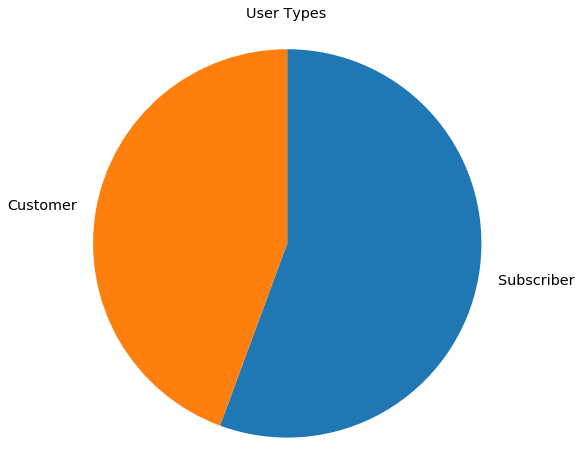

In [64]:
# Piechart user_type

plt.figure(figsize=[8,8])  

plt.title('User Types')  

def pie_user():
    sorted_counts = df_clean_eda['user_type'].value_counts()
    plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False);
    plt.axis('square');

pie_user()    

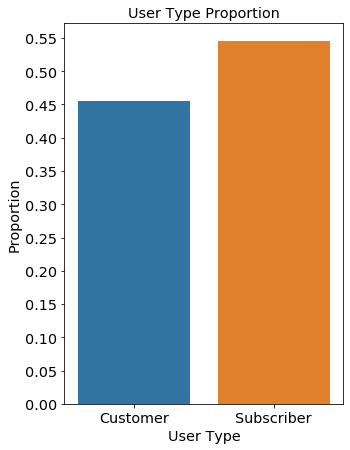

In [16]:
# Barchart user_type proportion

n = df_clean_eda.shape[0]
max_count = df['user_type'].value_counts().max()
max_prop = max_count / n

# Tick mark locations
tick_props = np.arange(0, 1, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

def graph_user_type():
    sb.countplot(data = df_clean_eda, x = 'user_type'); 
    plt.xlabel('User Type')
    plt.ylabel('Proportion')
    plt.title('User Type Proportion')

plt.figure(figsize=[5,7])
plt.yticks(tick_props * n, tick_names)

graph_user_type()

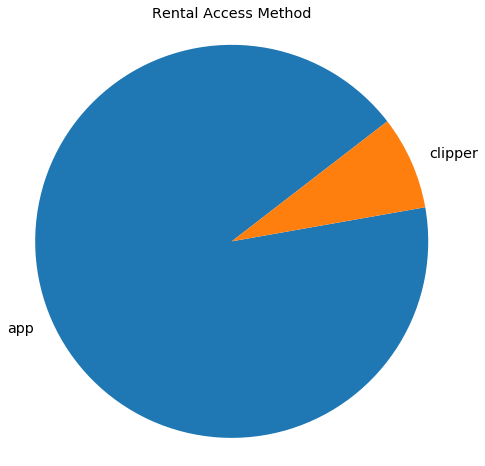

In [67]:
# Piechart rental_access_method

sorted_counts = df_clean_eda['rental_access_method'].value_counts()

plt.figure(figsize=[8,8])  

plt.title('Rental Access Method')  

def pie_rental():
    plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 10, counterclock = False);
    plt.axis('square');
    
pie_rental()

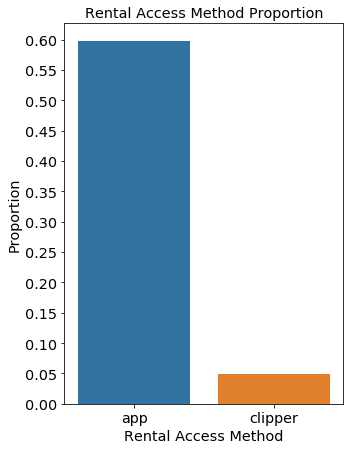

In [18]:
# Barchart rental_access_method proportion

n = df_clean_eda.shape[0]
max_count = df['rental_access_method'].value_counts().max()
max_prop = max_count / n

# Tick mark locations
tick_props = np.arange(0, 1, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

def graph_user_type():
    sb.countplot(data = df_clean_eda, x = 'rental_access_method'); 
    plt.xlabel('Rental Access Method')
    plt.ylabel('Proportion')
    plt.title('Rental Access Method Proportion')

plt.figure(figsize=[5,7])
plt.yticks(tick_props * n, tick_names)

graph_user_type()

The proportions in the rental access method, show us that almost 60% of the rentals are via the app, and only 5% via clipper. The rest are not identified and were not removed in this analysis. 

### Distances Analysis

In [19]:
# Verify distances values before plotting

df_clean_eda['distance_km'].describe()

count    176657.000000
mean          2.285372
std          74.589443
min           0.000000
25%           0.901365
50%           1.543855
75%           2.513332
max       12800.844329
Name: distance_km, dtype: float64

We can verify that some distances are equal to zero, and some distances are way too large. So we will remove distances smaller than 50 meters, a person can walk this distance, and larger than 25 km which seems to be too much for a rented bike ride. 

In [20]:
# Remove distances equal to zero. 
print('Before:', df_clean_eda['distance_km'].describe())

remove_dist = df_clean_eda.query('distance_km < 0.05 or distance_km > 25')

df_clean_eda = df_clean_eda[~df_clean_eda.index.isin(remove_dist.index)]

# Test
print('After:', df_clean_eda['distance_km'].describe())


Before: count    176657.000000
mean          2.285372
std          74.589443
min           0.000000
25%           0.901365
50%           1.543855
75%           2.513332
max       12800.844329
Name: distance_km, dtype: float64
After: count    169151.000000
mean          1.932256
std           1.317551
min           0.050053
25%           0.977250
50%           1.608040
75%           2.569324
max          22.383799
Name: distance_km, dtype: float64


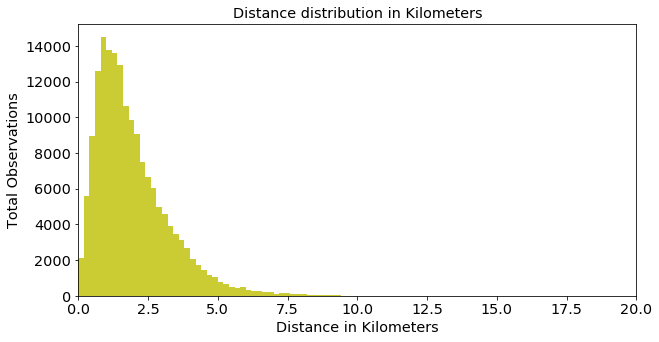

In [21]:
# Verify how the distances are distributed after assessing and cleaning.

binsize = 0.2
bins = np.arange(0, df_clean_eda['distance_km'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='y', x = 'distance_km', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Distance distribution in Kilometers')    
plt.ylabel('Total Observations')
plt.xlabel('Distance in Kilometers')
plt.xlim([0, 20])


plt.show(graph());

From plotting again, it is clear that the distribution is right-skewed, with almost all the values between 0 and 5 m. We will plot again with a limit of 10 km to take a closer look at the majority of observations.

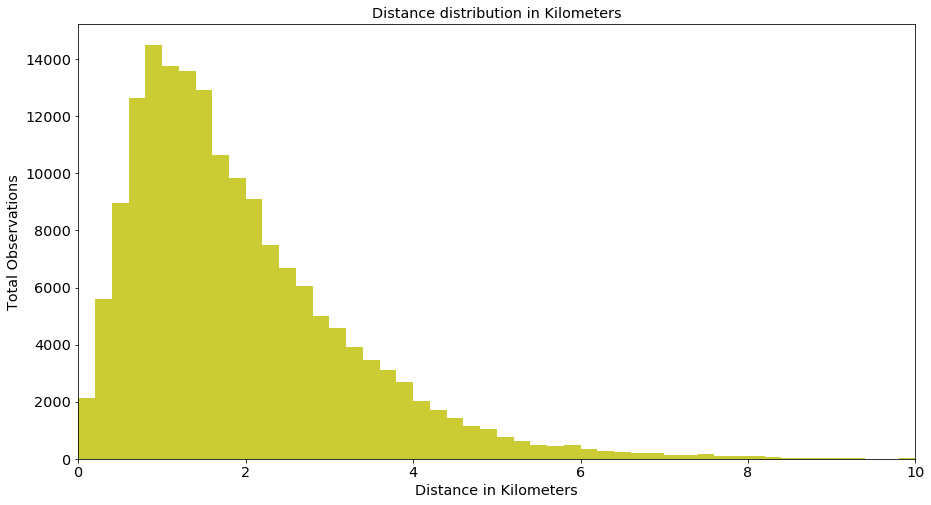

In [22]:
# Verify how the distances are distributed after assessing and cleaning with 10 km limit. 

binsize = 0.2
bins = np.arange(0, df_clean_eda['distance_km'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='y', x = 'distance_km', bins = bins)
    
plt.figure(figsize=[15,8])    
plt.title('Distance distribution in Kilometers')  
plt.ylabel('Total Observations')
plt.xlabel('Distance in Kilometers')
plt.xlim([0, 10])

plt.show(graph());

Let's shrink even more and look at the values between 0 km and 2 km.


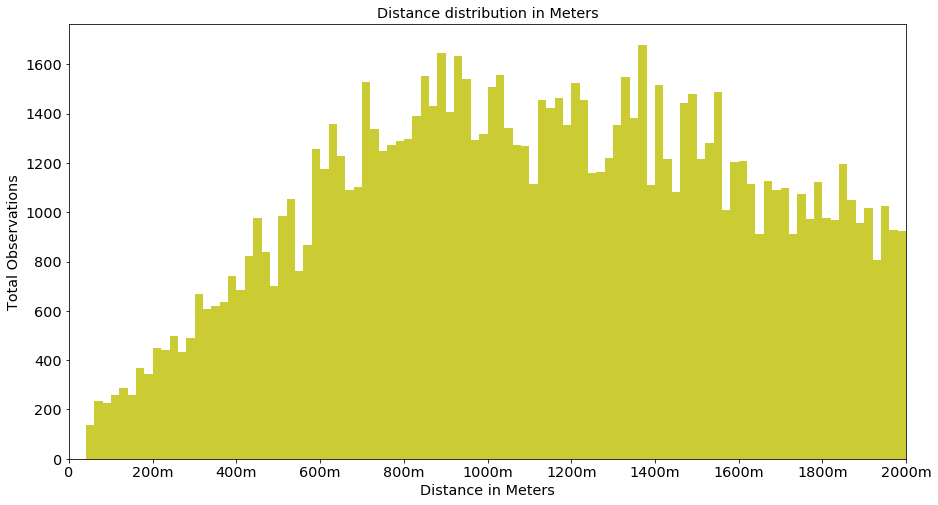

In [23]:
# Verify how the distances are distributed after assessing and cleaning with 2 km limit. 

binsize = 0.02
bins = np.arange(0, df_clean_eda['distance_km'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='y', x = 'distance_km', bins = bins)
    
plt.figure(figsize=[15,8])    
plt.title('Distance distribution in Meters')  
plt.ylabel('Total Observations')
plt.xlabel('Distance in Meters')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2],['0', '200m', '400m', '600m', '800m', '1000m', '1200m', '1400m', '1600m', '1800m', '2000m'])
plt.xlim([0, 2])

plt.show(graph());

From this visualization, we can verify that the most common distance biked by the users is between 800m and 1400m. 

### Distance Distribution

The distribution is right-skewed, with almost all the values between 0 and 5m. Let's have a closer look at the values between 0 and 2 kilometers of distance. From the second visualization, we can verify that the most common distance biked by the users is between 800m and 1400m. 

### Duration Analysis

In [24]:
# Verify trip duration values before plotting

df_clean_eda['duration_min'].describe()

count    169151.000000
mean         13.268174
std          13.543520
min           1.000000
25%           6.283333
50%           9.950000
75%          15.633333
max         299.566667
Name: duration_min, dtype: float64

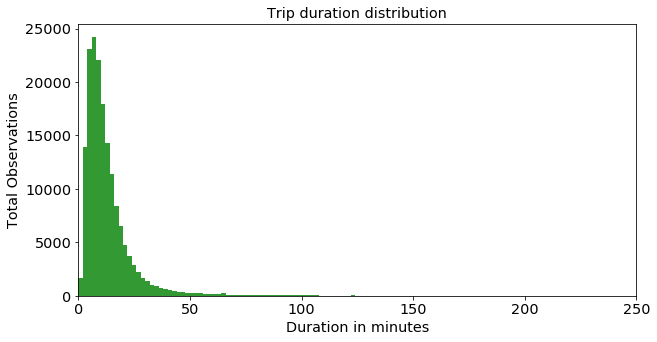

In [25]:
# Verify how the time in minutes is distributed

binsize = 2
bins = np.arange(0, df_clean_eda['duration_min'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='g', x = 'duration_min', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Trip duration distribution')    
plt.ylabel('Total Observations')
plt.xlabel('Duration in minutes')
plt.xlim([0, 250])

plt.show(graph());

From plotting the distribution of the time per trip, we can see that some values are longer than 3 hours, which seems a bit too much. We will remove those values and plot again.

In [26]:
# Remove duration over 3 hours or 160 minutes. 

print('Before:', df_clean_eda['duration_min'].describe())

remove_time = df_clean_eda.query('duration_min > 160')

df_clean_eda = df_clean_eda[~df_clean_eda.index.isin(remove_time.index)]

# Test
print('After:', df_clean_eda['distance_km'].describe())


Before: count    169151.000000
mean         13.268174
std          13.543520
min           1.000000
25%           6.283333
50%           9.950000
75%          15.633333
max         299.566667
Name: duration_min, dtype: float64
After: count    169003.000000
mean          1.931781
std           1.315995
min           0.050053
25%           0.977250
50%           1.608040
75%           2.569324
max          20.852021
Name: distance_km, dtype: float64


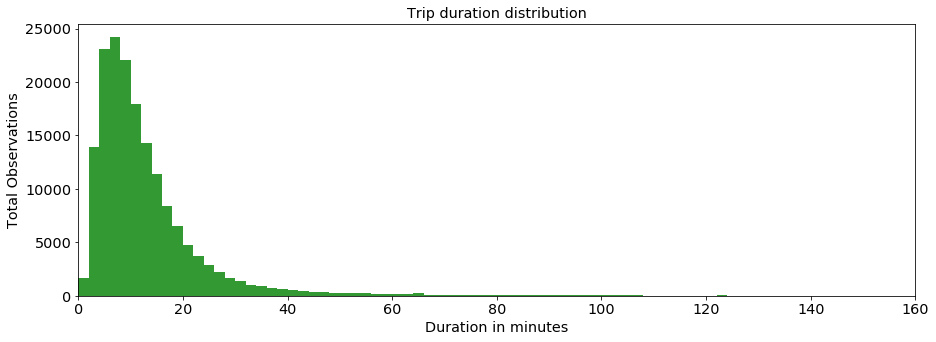

In [27]:
# Verify how the time in minutes is distributed after removing values over 4 hours

binsize = 2
bins = np.arange(0, df_clean_eda['duration_min'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='g', x = 'duration_min', bins = bins)
    

plt.title('Trip duration distribution')    
plt.ylabel('Total Observations')
plt.xlabel('Duration in minutes')
plt.xlim([0, 160])

plt.show(graph());

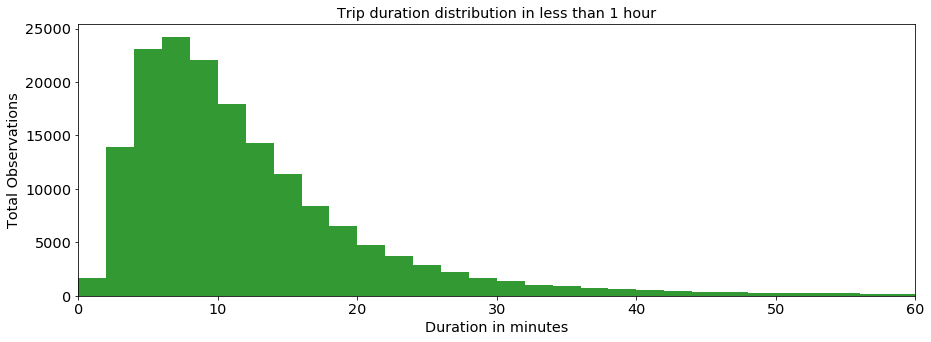

In [28]:
# Verify how the time in minutes is distributed

binsize = 2
bins = np.arange(0, df_clean_eda['duration_min'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='g', x = 'duration_min', bins = bins)
     
plt.title('Trip duration distribution in less than 1 hour')    
plt.ylabel('Total Observations')
plt.xlabel('Duration in minutes')
plt.xlim([0, 60])

plt.show(graph());

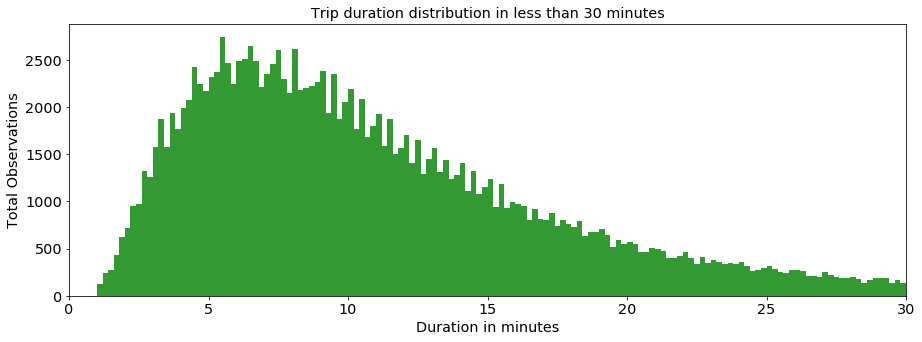

In [29]:
# Verify how the distances are distributed after assessing and cleaning with 2 km limit. 

binsize = 0.2
bins = np.arange(0, df_clean_eda['duration_min'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='g', x = 'duration_min', bins = bins)
    
plt.title('Trip duration distribution in less than 30 minutes')  
plt.ylabel('Total Observations')
plt.xlabel('Duration in minutes')
plt.xlim([0, 30])

plt.show(graph());

From the detailed distribution above, it is possible to see that after 10 minutes, the number of observations starts to decrease. People tend to spend between 5 and 10 minutes of biking. 

### Duration Distribution

From the detailed distribution above, it is possible to see that after 10 minutes, the number of observations starts to decrease. People tend to spend between 5 and 10 minutes of biking. 

### The Pace Analysis

In [30]:
df_clean_eda['pace_km_h'].describe()

count    169003.000000
mean         10.319030
std           3.957514
min           0.034432
25%           8.009407
50%          10.510836
75%          12.901727
max         113.837167
Name: pace_km_h, dtype: float64

From the table above, we can verify that the maximum pace is 113 km/h which is impossible to be achieved when biking. We will consider 30 km/h the maximum pace considering it is a normal bicycle and normal cyclists. 

In [31]:
# Remove pace records over 30 km/h

print('Before:', df_clean_eda['pace_km_h'].describe())

remove_pace = df_clean_eda.query('pace_km_h > 30')

df_clean_eda = df_clean_eda[~df_clean_eda.index.isin(remove_pace.index)]

# Test
print('After:', df_clean_eda['pace_km_h'].describe())


Before: count    169003.000000
mean         10.319030
std           3.957514
min           0.034432
25%           8.009407
50%          10.510836
75%          12.901727
max         113.837167
Name: pace_km_h, dtype: float64
After: count    169000.000000
mean         10.318143
std           3.948710
min           0.034432
25%           8.009388
50%          10.510825
75%          12.901585
max          26.428188
Name: pace_km_h, dtype: float64


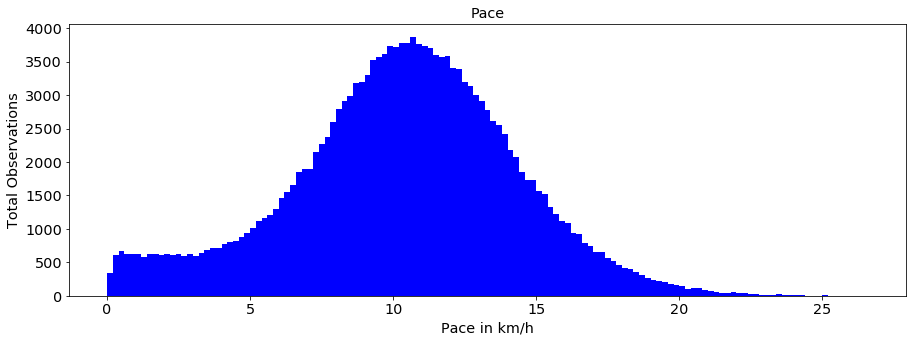

In [32]:
# Verify how the pace is distributed

binsize = 0.2
bins = np.arange(0, df_clean_eda['pace_km_h'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, facecolor='b', x = 'pace_km_h', bins = bins)

plt.title('Pace')    
plt.ylabel('Total Observations')
plt.xlabel('Pace in km/h')

plt.show(graph());

### The Pace Distribution

The pace is a normal distribution, different from distance and time. From the plot, we can also verify that there are some pace values below 3 km/h which is walking speed. Those might be users that took the bike but for whatever reason walked the bike until the destination station. We can remove those users. 

In [33]:
# Remove pace records over 30 km/h

print('Before:', df_clean_eda['pace_km_h'].describe())

remove_pace = df_clean_eda.query('pace_km_h < 3')

df_clean_eda = df_clean_eda[~df_clean_eda.index.isin(remove_pace.index)]

# Test
print('After:', df_clean_eda['pace_km_h'].describe())


Before: count    169000.000000
mean         10.318143
std           3.948710
min           0.034432
25%           8.009388
50%          10.510825
75%          12.901585
max          26.428188
Name: pace_km_h, dtype: float64
After: count    159997.000000
mean         10.812180
std           3.442148
min           3.000725
25%           8.480987
50%          10.739332
75%          13.049928
max          26.428188
Name: pace_km_h, dtype: float64


### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations? ###
There were some unusual points in the data like distances too large to be covered by bike and, some biking times were also too large to be true and some were equal to zero. For the zero ones, my best assumption is that the person rented a bike, had some problems, and ended up giving the bike back or some other issue with the system. I also added two new columns to represent the distance, calculated using latitude and longitude, and the user's pace. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this? ###

Firstly, I defined what operations were needed to tidy and adjust the data. Starting from the distance in kilometers I removed distances smaller than 50 meters, a person can walk this distance, and larger than 25 km which seems to be too much for a rented bike ride. Secondly, I removed trip duration records longer than 3 hours. When checking the pace, I found large values, too large to be achieved by biking and walking paces. Those extreme values were also removed.

## Bivariate Exploration

In [34]:
numeric_vars = ['distance_km', 'pace_km_h', 'duration_min','start_station_latitude', 'start_station_longitude','end_station_latitude', 'end_station_longitude']
numeric_vars_short = ['distance_km', 'pace_km_h', 'duration_min']
                
categoric_vars = ['user_type','rental_access_method']

### Heat Maps


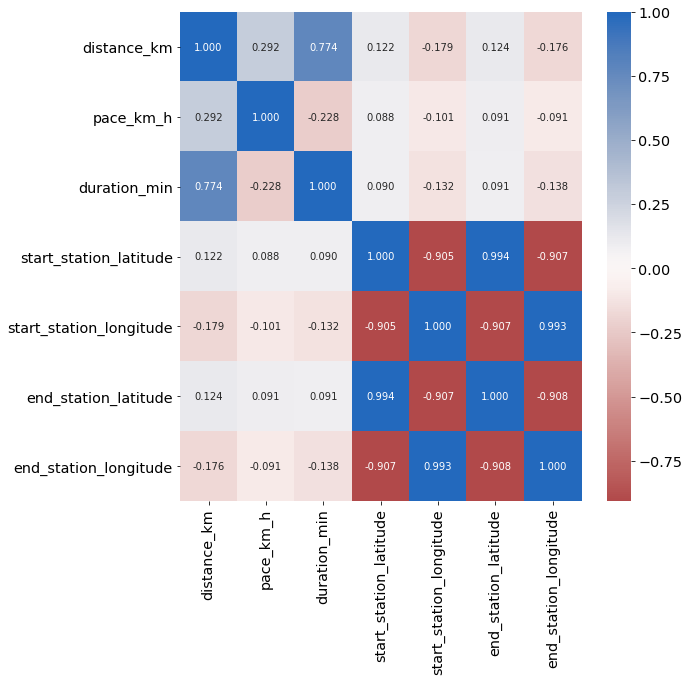

In [35]:
plt.figure(figsize=[9,9])   

def graph():
    sb.heatmap(df_clean_eda[numeric_vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center=0)
    
graph()    

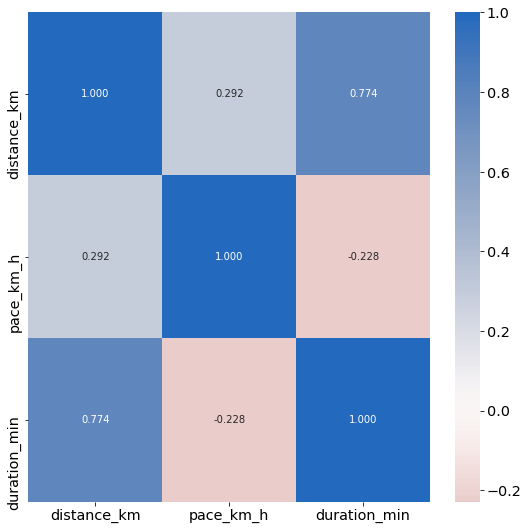

In [36]:
# Correlation plot 
plt.figure(figsize=[9,9])   

def graph():
    sb.heatmap(df_clean_eda[numeric_vars_short].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center=0)
    
graph()    

The heatmap between the numeric variables shows us that distance and duration correlate .77. Since it is common sense to use km/h and m/s, we will analyze a scatter plot between time and distance in meters per second. 

### Correlation

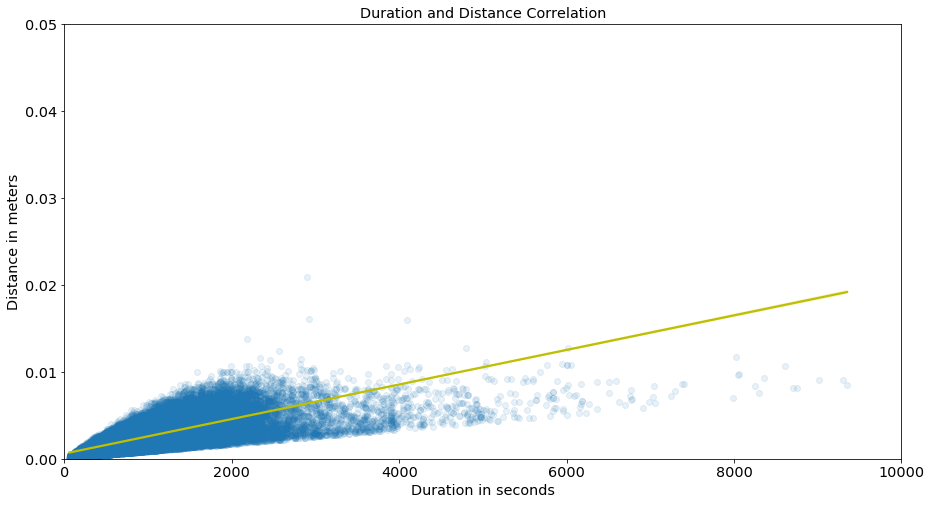

In [60]:
# Scatter plot for duration and distance

ds = df_clean_eda['duration_sec']
dk = df_clean_eda['distance_km']/1000

def graph():
    sb.regplot(ds, dk, color='y', scatter=False);
    sb.regplot(ds, dk, fit_reg=False, scatter_kws = {'alpha':0.1});
    plt.ylabel('Distance in meters')
    plt.xlabel('Duration in seconds')

plt.figure(figsize=[15,8])
plt.grid(False)
plt.title('Duration and Distance Correlation')
plt.ylim([0, 0.05])
plt.xlim([0, 10000])

graph()

The positive correlation is now verified in a scatter plot. When the duration of the trip increases, the distance covered tends to increase too. 

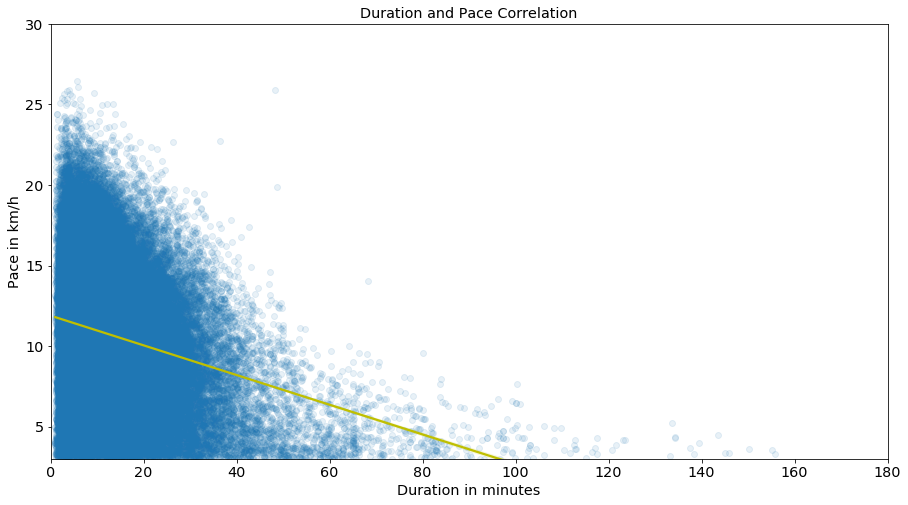

In [61]:
# Scatter plot for pace and duration

pc = df_clean_eda['pace_km_h']
dm = df_clean_eda['duration_min']

def graph():
    sb.regplot(dm, pc, color='y', scatter=False);
    sb.regplot(dm, pc, fit_reg=False, scatter_kws = {'alpha':0.1});
    plt.ylabel('Pace in km/h')
    plt.xlabel('Duration in minutes')

plt.figure(figsize=[15,8])
plt.grid(False)
plt.title('Duration and Pace Correlation')
plt.ylim([3, 30])
plt.xlim([0, 180])

graph()

Differently from time and distance correlation, the correlation between pace and time is negative. From the scatter plot above, we can verify the yellow regression line going downwards. This shows a negative correlation, meaning that when the time spent on the bike increases, the pace tends to decrease. It makes a lot of sense! The cyclist eventually gets tired, takes more time no bike and the pacing rate fades. 

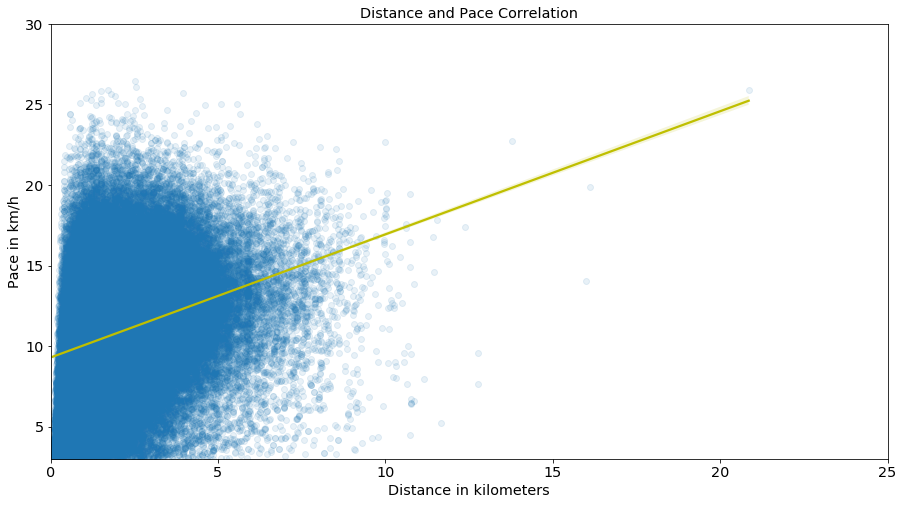

In [62]:
# Scatter plot for pace and distance

pc = df_clean_eda['pace_km_h']
dk = df_clean_eda['distance_km']

def graph():
    sb.regplot(dk, pc, color='y', scatter=False);
    sb.regplot(dk, pc, fit_reg=False, scatter_kws = {'alpha':0.1});
    plt.ylabel('Pace in km/h')
    plt.xlabel('Distance in kilometers')

plt.figure(figsize=[15,8])
plt.grid(False)
plt.title('Distance and Pace Correlation')
plt.ylim([3, 30])
plt.xlim([0, 25])

graph()

Now that's interesting, when the duration increases, the pace fades but when the distance increases, the pace also increases. One reasonable explanation is that the body takes some time to head up and reach the peak of performance. The cyclist needs some minimum distance to start performing and reach the peak of performance. From the scatter plot we can also verify the existence of an outlier. That cyclist did more than 20 km with a pace of 25 km/h. 

### Violin and Box Visualizations

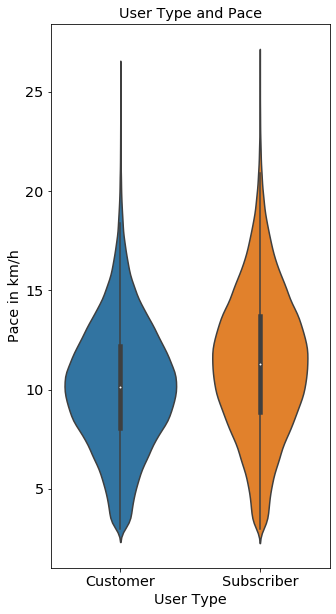

In [40]:
# Violin chart for User Type and Pace

def graph():
    sb.violinplot(data = df_clean_eda, x = 'user_type', y = 'pace_km_h');
    plt.ylabel('Pace in km/h')
    plt.xlabel('User Type')
    
plt.figure(figsize=[5,10])
plt.title('User Type and Pace')

graph()

Between customers (casual users) and subscribers (members), we can verify that subscribers have a maximum pace lower than casual users. On the other hand, their pace distribution is smoother than the customers. From the violin plot, we can also verify that there are more records inside the interquartile 75% mark in the members (subscribers) than the customers. Subscribers also have the fastest cyclist.  

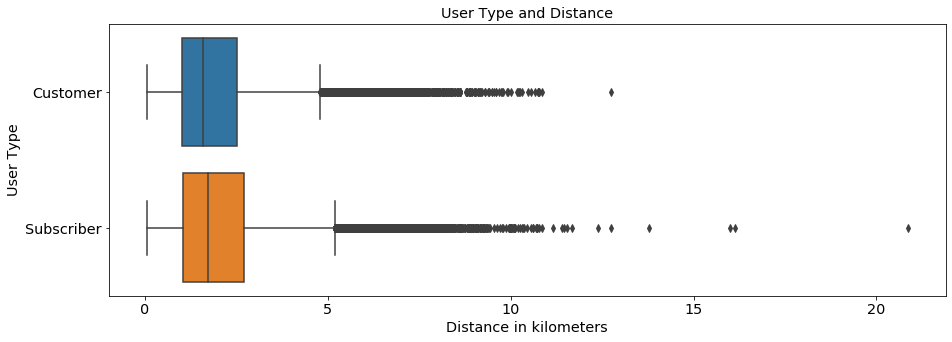

In [41]:
# Box chart for User Type and Distance

def graph():
    sb.boxplot(data = df_clean_eda, x = 'distance_km', y = 'user_type')
    plt.ylabel('User Type')
    plt.xlabel('Distance in kilometers')
    
plt.figure(figsize=[15,5])
plt.ylim([0, 8])
plt.title('User Type and Distance')

graph()

By comparing the user type to the distance covered, we can verify that members (subscribed users) tend to cover longer distances but it is very close compared to customers. The outliers are also close in comparison. The cyclist that covered the larger distance is subscribed. 

### Categorical and Numeric Distribution

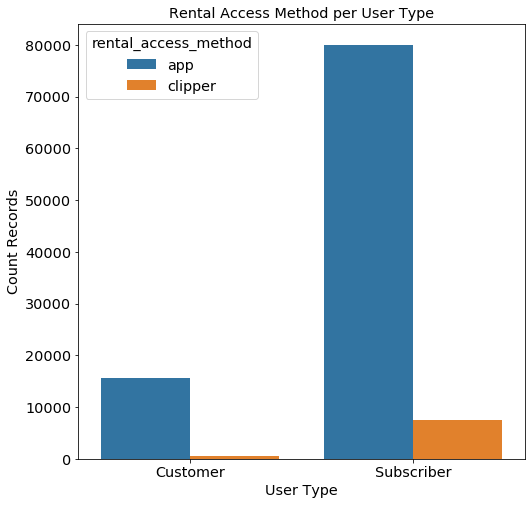

In [42]:
# Clustered Barchart for User Type and Rental Access Method

def graph():
    sb.countplot(data = df_clean_eda, x = 'user_type', hue = 'rental_access_method')    
    plt.ylabel('Count Records')
    plt.xlabel('User Type')
    
plt.figure(figsize=[8,8])

plt.title('Rental Access Method per User Type')

graph()

The clustered bar chart above shows us that members are the majority of the APP users. There is a good chance that if you are a member, you'll use the APP to rent a bike. Only a few members use Clipper as the access method. 

### Features of Interest X Other Features

Let's first divide the periods of the day into five main periods, that way we can analyze any outcoming relationship.

In [43]:
# Create a copy of the cleaned Data frame 

df_other = df_clean_eda.copy()


In [44]:
# Split the timestamp in different columns.

df_other['hour_of_the_day'] = df_other['start_time'].dt.strftime('%H:%M')

df_other.head()


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method,distance_km,pace_km_h,duration_min,hour_of_the_day
3,1068,2020-03-31 23:55:00.426,2020-04-01 00:12:49.020,456.0,Arguello Blvd at Geary Blvd,37.781468,-122.458806,107.0,17th St at Dolores St,37.763015,-122.426497,12955,Customer,NaN,3.504582,11.813196,17.800000,23:55
5,1232,2020-03-31 23:29:19.395,2020-03-31 23:49:52.252,152.0,47th St at San Pablo Ave,37.835632,-122.281051,195.0,Bay Pl at Vernon St,37.812314,-122.260779,9746,Customer,NaN,3.146346,9.193869,20.533333,23:29
6,368,2020-03-31 23:35:03.834,2020-03-31 23:41:12.221,458.0,Frederick St at Arguello Blvd,37.765783,-122.457637,70.0,Central Ave at Fell St,37.773311,-122.444293,11057,Customer,NaN,1.441416,14.100806,6.133333,23:35
7,659,2020-03-31 23:22:37.945,2020-03-31 23:33:37.220,253.0,Haste St at College Ave,37.866418,-122.253799,241.0,Ashby BART Station,37.852477,-122.270213,10488,Customer,NaN,2.117157,11.565651,10.983333,23:22
8,989,2020-03-31 23:03:41.104,2020-03-31 23:20:10.816,148.0,Horton St at 40th St,37.829705,-122.287610,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,11552,Customer,NaN,4.060701,14.781115,16.483333,23:03


In [45]:
# Create categorical variable for hour of the day.

# Setting night when creating the column is to fix a bug of not setting "night" in the code below. 
df_other['period'] = 'night'

df_other.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method,distance_km,pace_km_h,duration_min,hour_of_the_day,period
3,1068,2020-03-31 23:55:00.426,2020-04-01 00:12:49.020,456.0,Arguello Blvd at Geary Blvd,37.781468,-122.458806,107.0,17th St at Dolores St,37.763015,-122.426497,12955,Customer,NaN,3.504582,11.813196,17.800000,23:55,night
5,1232,2020-03-31 23:29:19.395,2020-03-31 23:49:52.252,152.0,47th St at San Pablo Ave,37.835632,-122.281051,195.0,Bay Pl at Vernon St,37.812314,-122.260779,9746,Customer,NaN,3.146346,9.193869,20.533333,23:29,night
6,368,2020-03-31 23:35:03.834,2020-03-31 23:41:12.221,458.0,Frederick St at Arguello Blvd,37.765783,-122.457637,70.0,Central Ave at Fell St,37.773311,-122.444293,11057,Customer,NaN,1.441416,14.100806,6.133333,23:35,night
7,659,2020-03-31 23:22:37.945,2020-03-31 23:33:37.220,253.0,Haste St at College Ave,37.866418,-122.253799,241.0,Ashby BART Station,37.852477,-122.270213,10488,Customer,NaN,2.117157,11.565651,10.983333,23:22,night
8,989,2020-03-31 23:03:41.104,2020-03-31 23:20:10.816,148.0,Horton St at 40th St,37.829705,-122.287610,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,11552,Customer,NaN,4.060701,14.781115,16.483333,23:03,night


In [46]:
# Create Columns for different time ranges 

size = df_other.shape[0]

for _ in df_other.index:
    if df_other['hour_of_the_day'][_] >= "05:00" and df_other['hour_of_the_day'][_] < "12:00": # Morning
        df_other['period'][_] = 'morning'
    if df_other['hour_of_the_day'][_] >= "12:00" and df_other['hour_of_the_day'][_] < "17:00": # Afternoon
        df_other['period'][_] = 'afternoon'
    if df_other['hour_of_the_day'][_] >= "17:00" and df_other['hour_of_the_day'][_] < "21:00": # Evening
        df_other['period'][_] = 'evening'
    if df_other['hour_of_the_day'][_] >= "21:00" and df_other['hour_of_the_day'][_] < "05:00": # Night
        df_other['period'][_] = 'night'
        #else:
        #    df_other['period'][_] = 'not identified'
        
df_other.head()
    


/Users/Eduardo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Eduardo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Eduardo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method,distance_km,pace_km_h,duration_min,hour_of_the_day,period
3,1068,2020-03-31 23:55:00.426,2020-04-01 00:12:49.020,456.0,Arguello Blvd at Geary Blvd,37.781468,-122.458806,107.0,17th St at Dolores St,37.763015,-122.426497,12955,Customer,NaN,3.504582,11.813196,17.800000,23:55,night
5,1232,2020-03-31 23:29:19.395,2020-03-31 23:49:52.252,152.0,47th St at San Pablo Ave,37.835632,-122.281051,195.0,Bay Pl at Vernon St,37.812314,-122.260779,9746,Customer,NaN,3.146346,9.193869,20.533333,23:29,night
6,368,2020-03-31 23:35:03.834,2020-03-31 23:41:12.221,458.0,Frederick St at Arguello Blvd,37.765783,-122.457637,70.0,Central Ave at Fell St,37.773311,-122.444293,11057,Customer,NaN,1.441416,14.100806,6.133333,23:35,night
7,659,2020-03-31 23:22:37.945,2020-03-31 23:33:37.220,253.0,Haste St at College Ave,37.866418,-122.253799,241.0,Ashby BART Station,37.852477,-122.270213,10488,Customer,NaN,2.117157,11.565651,10.983333,23:22,night
8,989,2020-03-31 23:03:41.104,2020-03-31 23:20:10.816,148.0,Horton St at 40th St,37.829705,-122.287610,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,11552,Customer,NaN,4.060701,14.781115,16.483333,23:03,night


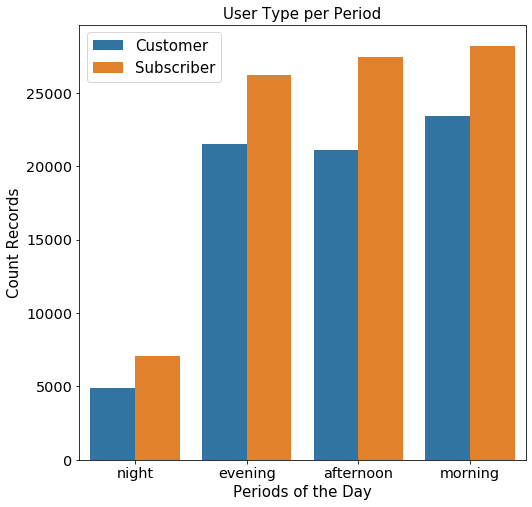

In [47]:
# Clustered Barchart for Period and User Type

def graph():
    sb.countplot(data = df_other, x = 'period', hue = 'user_type')    
    plt.ylabel('Count Records', fontsize=15)
    plt.xlabel('Periods of the Day', fontsize=15)
    plt.legend(fontsize=15)
    
plt.figure(figsize=[8,8])

plt.title('User Type per Period', fontsize=15)

graph()

Subscribers are the majority of the users in all periods of the day. 

In [48]:
# Verify night period.

print('Before:',df_other['period'].unique())


Before: ['night' 'evening' 'afternoon' 'morning']


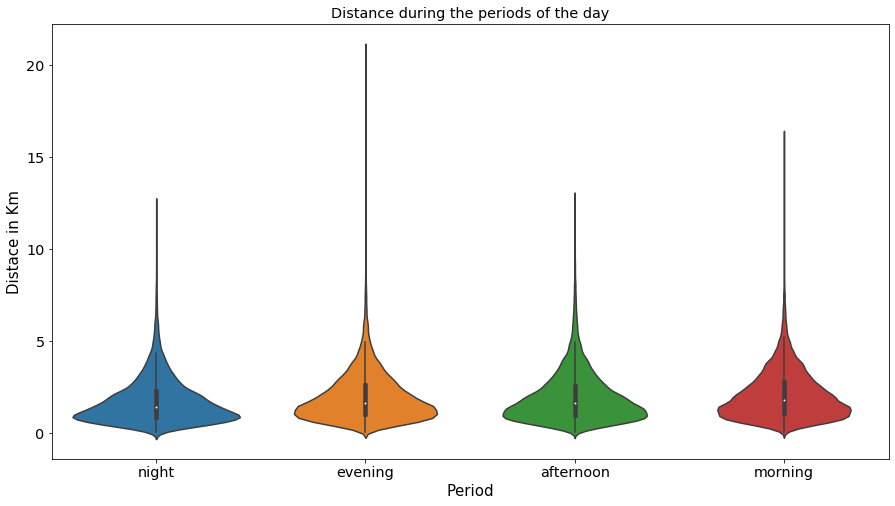

In [49]:
# Violin chart for User Type and Pace

def graph():
    sb.violinplot(data = df_other, x = 'period', y = 'distance_km');
    plt.ylabel('Distace in Km', fontsize=15)
    plt.xlabel('Period', fontsize=15)
    
plt.figure(figsize=[15,8])
plt.title('Distance during the periods of the day')

graph()

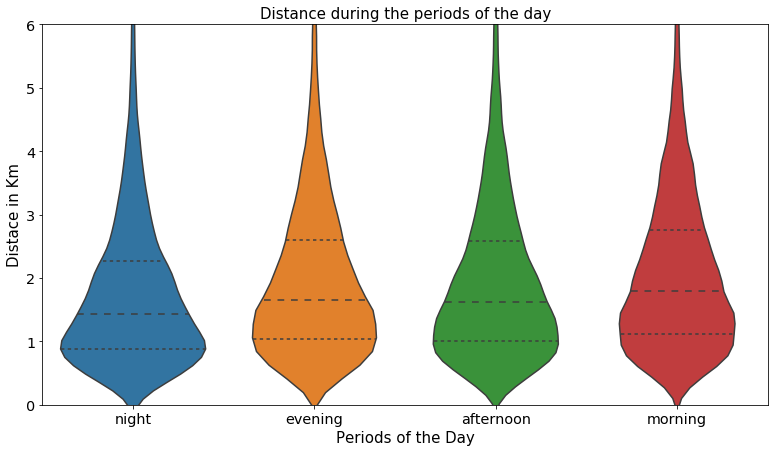

In [50]:
# Violin chart for User Type and Pace

def graph():
    sb.violinplot(data = df_other, x = 'period', y = 'distance_km', inner = 'quartile', fontsize=15);
    plt.ylabel('Distace in Km', fontsize=15)
    plt.xlabel('Periods of the Day', fontsize=15)
    
plt.figure(figsize=[13,7])
plt.ylim([0, 6])
plt.title('Distance during the periods of the day', fontsize=15)

graph()

People tend to use the bike to cover smaller distances during the night. The evening and afternoon periods have similar distance patterns. The morning period has a smoother distribution of distance covered. 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

Time and distance have a positive correlation which makes sense and pace was a good surprise. The performance of the cyclist is something that has to be considered when comparing the distance covered with the pace. The pace tends to get better in longer distances most probably due to performance peak. People tend to use the bike to cover smaller distances during the night. 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?
One interesting relationship is between the periods of the day and the user type. Subscribed users are the majority in all periods of the day. 

## Multivariate Exploration


In [51]:
# Create a copy of the last Data frame 

df_multi = df_other.copy()

### User Type X Distance and Time

In [52]:
# User Type, distance and time

# Regplot with normal size
def graph_user_type():
    
    ttype_markers = [['Customer', 'o'],
                     ['Subscriber', 'o']]
    
    plt.figure(figsize=[11,11])
    plt.title('Distance and Duration per User Type', fontsize=15)

    for ttype, marker in ttype_markers:
        plot_data = df_multi.loc[df_multi['user_type'] == ttype]
        sb.regplot(data = plot_data, x='distance_km', y='duration_min', fit_reg = False, marker = marker);
        plt.legend(['Customer', 'Subscriber'], fontsize=15)
        plt.xlabel('Distace in Km', fontsize=15)
        plt.ylabel('Duration in minutes', fontsize=15)
        plt.ylim([0, 160])
        plt.xlim([0, 25])


# Regplot zoomed         
def graph_user_type_zoom():
    
    ttype_markers = [['Customer', 'o'],
                     ['Subscriber', 'o']]
    
    plt.figure(figsize=[11,11])
    plt.title('Distance and Duration per User Type', fontsize=15)

    for ttype, marker in ttype_markers:
        plot_data = df_multi.loc[df_multi['user_type'] == ttype]
        sb.regplot(data = plot_data, x='distance_km', y='duration_min', fit_reg = False, marker = marker);
        plt.legend(['Customer', 'Subscriber'], fontsize=15)
        plt.xlabel('Distace in Km', fontsize=15)
        plt.ylabel('Duration in minutes', fontsize=15)
        plt.ylim([20, 100])
        plt.xlim([2, 10])



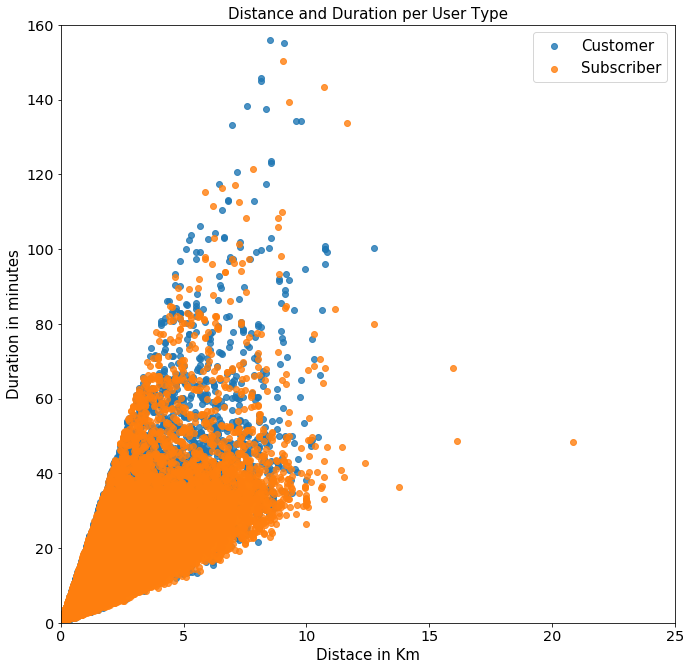

In [53]:
graph_user_type()

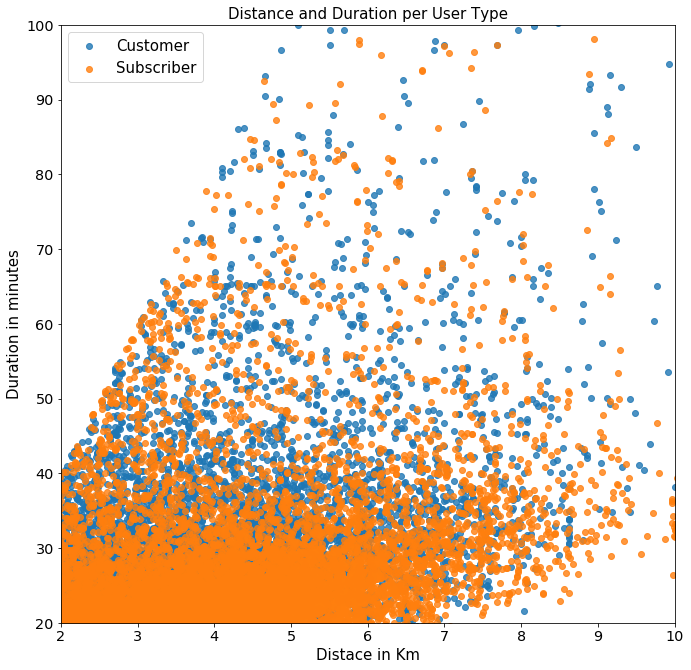

In [54]:
graph_user_type_zoom()


The first analysis in Multivariate Exploration is between the categorical variable User Type and the two numeric variables Distance in Km and Duration in Minutes. In the first plot, we can see that customers are the majority after 40 minutes of biking. So in the second graph, we zoomed in to analyze this difference. When zooming in, the difference becomes even more clear. We can see that the differences in duration started before the 40 minutes mark, around the 30 minutes mark. 

### Periods X Distance and Time

In [55]:
# Periods, distance and time

# Regplot with normal size
def graph_period():
    
    ttype_markers = [['night', 'o'],
                     ['evening', 'o'],
                     ['afternoon', 'o'],
                     ['morning', 'o']]

    plt.figure(figsize=[11,11])
    plt.title('Distance and Duration per Period', fontsize=15)    
    
    for ttype, marker in ttype_markers:
        plot_data = df_multi.loc[df_multi['period'] == ttype]
        sb.regplot(data = plot_data, x='distance_km', y='duration_min', fit_reg = False, marker = marker);
        plt.legend(['Night', 'Evening', 'Afternoon', 'Morning'], fontsize=15)
        plt.xlabel('Distace in Km', fontsize=15)
        plt.ylabel('Duration in minutes', fontsize=15)
        plt.ylim([0, 160])
        plt.xlim([0, 25])

# Regplot zoomed         
def graph_period_zoom():
    
    ttype_markers = [['night', 'o'],
                     ['evening', 'o'],
                     ['afternoon', 'o'],
                     ['morning', 'o']]

    plt.figure(figsize=[11,11])
    plt.title('Distance and Duration per Period', fontsize=15)
    
    for ttype, marker in ttype_markers:
        plot_data = df_multi.loc[df_multi['period'] == ttype]
        sb.regplot(data = plot_data, x='distance_km', y='duration_min', fit_reg = False, marker = marker);
        plt.legend(['Night', 'Evening', 'Afternoon', 'Morning'], fontsize=15)
        plt.xlabel('Distace in Km', fontsize=15)
        plt.ylabel('Duration in minutes', fontsize=15)
        plt.ylim([30, 160])
        plt.xlim([3, 25])

        
# Facet


def graph_period_facet():
    
    ttype_markers = [['night', 'o'],
                     ['evening', 'o'],
                     ['afternoon', 'o'],
                     ['morning', 'o']]

    
    g = sb.FacetGrid(data = df_multi, col = 'period')
    
    g.map(plt.scatter, 'distance_km', 'duration_min')
    
    

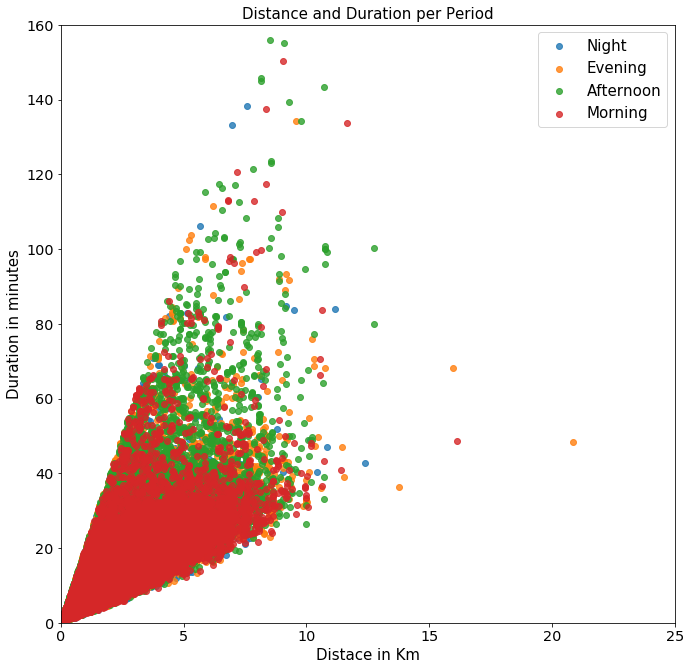

In [56]:
graph_period()

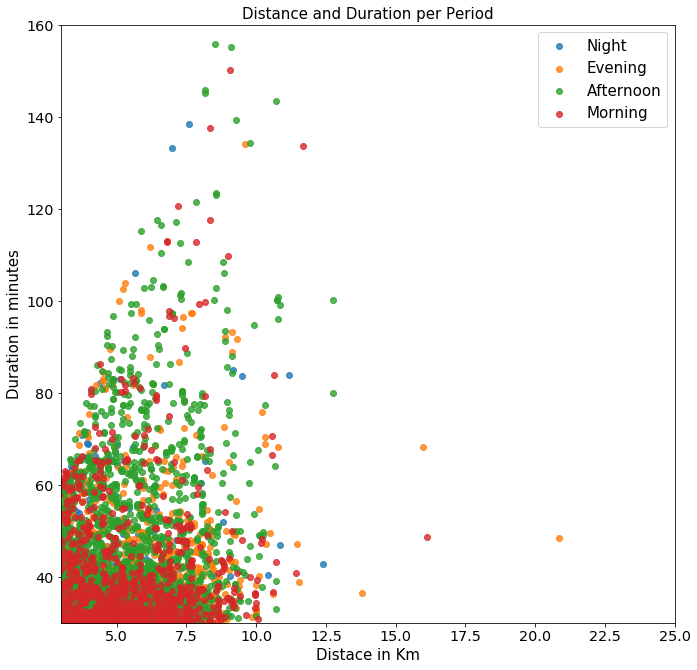

In [57]:
graph_period_zoom()

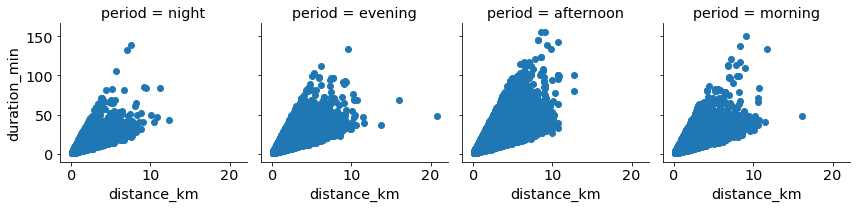

In [58]:
graph_period_facet()

The second analysis is between the periods of the day and again, distance and duration. The first graph shows us that the afternoon period is dominant after 40 minutes of biking. Again, we zoom in tho have a closer look. Now it is clear that night is the minority of records and afternoon the majority. Morning rides tend to end before 50 minutes and about 7.5 kilometers of distance. Afternoon rides have more chance of being longer rides in time, distance is almost the same for evening, afternoon and morning. 

In the graphs above, we can see the differences between morning and afternoon especially with the duration in distances smaller than 5 km. During the morning people tend to bike faster than during the afternoon, in distances smaller than 5 km. The afternoon duration distribution is smoother. 


### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?
Definitely! When analyzing the duration per period of the day, we could see that during the morning, people tend to bike faster than during the afternoon in distances smaller than 5 km. However, the afternoon period is dominant after 40 minutes of biking. Morning rides tend to end before 50 minutes and 7.5 kilometers of distance. 

### Were there any interesting or surprising interactions between features?
I think one good surprise was how customers were the majority of users after 40 minutes of biking. This shows us that members are engaged in using the bike for longer periods. Another good surprise was the bike usage during the night period between 21:00 and 5:00. We could observe that people use the service to cover smaller distances, maybe to avoid walking during the night. 

## Conclusions
    - Distance and time are correlated and influenced by the periods of the day.  
    - The user type has a small influence on distance and time. 
    - The periods of the day have a direct influence on distance and time.  

In [ ]:
!jupyter nbconvert bay-wheels.ipynb --to slides --post serve --template output_toggle

[NbConvertApp] Converting notebook bay-wheels.ipynb to slides
[NbConvertApp] Writing 1909229 bytes to bay-wheels.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/bay-wheels.slides.html
Use Control-C to stop this server
